In [ ]:
# Installing Dependancies

!pip install kora -q
import kora.install.rdkit
import sys
import numpy as np
from numpy.testing import assert_allclose
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 


In [ ]:
filename = '10k_rndm_zinc_drugs_clean.txt'
with open(filename) as f:
    	raw_text = "\n".join(line.strip() for line in f)

unique_chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
char_to_int.update({-1 : "\n"})

int_to_char = dict((i, c) for i, c in enumerate(unique_chars))
int_to_char.update({"\n" : -1})

mapping_size = len(char_to_int)
reverse_mapping_size = len(int_to_char)
print ("Size of the character to integer dictionary is: ", mapping_size)
print ("Size of the integer to character dictionary is: ", reverse_mapping_size)

Size of the character to integer dictionary is:  35
Size of the integer to character dictionary is:  35


In [ ]:
assert mapping_size == reverse_mapping_size

In [ ]:
n_chars = len(raw_text)
n_vocab = len(unique_chars)

print ("Total number of characters in the file is: ", n_chars)

seq_length = 137
dataX = []
dataY = []

for i in range(0, n_chars - seq_length, 1):
	seq_in = raw_text[i:i + seq_length]
	seq_out = raw_text[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])

n_patterns = len(dataX)

X = np.reshape(dataX, (n_patterns, seq_length, 1))

X = X / float(n_vocab)

Y = np_utils.to_categorical(dataY)

Total number of characters in the file is:  453342


In [ ]:
"""CREATING THE LSTM MODEL"""

model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(512, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.25))
model.add(LSTM(128))
model.add(Dropout(0.25))
model.add(Dense(Y.shape[1], activation='softmax'))

print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 137, 128)          66560     
_________________________________________________________________
dropout (Dropout)            (None, 137, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 137, 256)          394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 137, 256)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 137, 512)          1574912   
_________________________________________________________________
dropout_2 (Dropout)          (None, 137, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 137, 256)          7

In [ ]:
from keras.callbacks import History 
history = History()
model.compile(loss = 'categorical_crossentropy', optimizer='adam')

filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')
callbacks_list = [checkpoint]

## Fit the model
history = model.fit(X, Y, epochs = 25, batch_size = 128, callbacks = callbacks_list)

# """TO TRAIN FROM SAVED CHECKPOINT"""
# # Load weights
# model.load_weights("weights-improvement-75-1.8144.hdf5")

# # load the model
# new_model = load_model("model.h5")
# assert_allclose(model.predict(x_train),
#                 new_model.predict(x_train),
#                 1e-5)

# # fit the model
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.fit(x_train, y_train, epochs = 100, batch_size = 64, callbacks = callbacks_list)

Epoch 1/25
3541/3541 [==============================] - 501s 131ms/step - loss: 2.6714

Epoch 00001: loss improved from inf to 2.66047, saving model to weights-improvement-01-2.6605.hdf5
Epoch 2/25
3541/3541 [==============================] - 467s 132ms/step - loss: 2.6497

Epoch 00002: loss improved from 2.66047 to 2.64959, saving model to weights-improvement-02-2.6496.hdf5
Epoch 3/25
3541/3541 [==============================] - 466s 132ms/step - loss: 2.6486

Epoch 00003: loss improved from 2.64959 to 2.64736, saving model to weights-improvement-03-2.6474.hdf5
Epoch 4/25
3541/3541 [==============================] - 466s 132ms/step - loss: 2.6455

Epoch 00004: loss improved from 2.64736 to 2.64603, saving model to weights-improvement-04-2.6460.hdf5
Epoch 5/25
3541/3541 [==============================] - 466s 132ms/step - loss: 2.6465

Epoch 00005: loss improved from 2.64603 to 2.64531, saving model to weights-improvement-05-2.6453.hdf5
Epoch 6/25
3541/3541 [===========================

Seed:
" CC(=O)NN1C(=O)N[C@](C)(c2ccccc2)C1=O)c1ccccc1
Clc1ccc(/C=N\c2ccc3c(c2)OCCOCCOCCOCCO3)c(Cl)c1
COCCn1c(SCC(F)(F)F)nc2ccccc21
CCNc1nnc(S[C@@ "
ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc
Done.


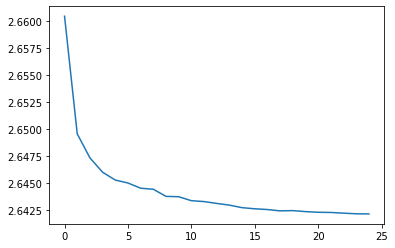

In [ ]:
import matplotlib.pyplot as plt
import numpy

plt.plot(history.history['loss'])

"""GENERATING NEW SMILES"""

filename = "weights-improvement-25-2.6422.hdf5"
model.load_weights(filename)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Pick a random seed from the SMILES strings
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print ("Seed:")
print ("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

for i in range(137):
	x = np.reshape(pattern, (1, len(pattern), 1))
	prediction = model.predict(x, verbose=0)
	index = np.argmax(prediction)
	result = int_to_char[index]
	seq_in = [int_to_char[value] for value in pattern]
	sys.stdout.write(result)
	pattern.append(index)
	pattern = pattern[1:len(pattern)]
print ("\nDone.")